# Exploration of Uber & Lyft Demand in the City of Chicago

### Section 1: Business Understanding

The rapid growth of private transportation network companies (TNC), such as Uber and Lyft, has fundamentally changed how people commute in urban areas. The growing demand has several implications, including but not limited to increased individual efficiency and increased overall congestion. This project aims to dig deeper into the topic. Mainly, this project explores the following topics:

Topic 1: General Demand for Ride-Hailing Services  
Topic 2: Geographic Distribution of Ride-Hailing Services  
Topic 3: Evaluation of Congestion  
Topic 4: Evaluation of Ride-Sharing  


Reference: https://www.cmap.illinois.gov/updates/all/-/asset_publisher/UIMfSLnFfMB6/content/new-data-allows-an-initial-look-at-ride-hailing-in-chicago

### Section 2: Data Understanding
**Import Necessary Packages** 

In [5]:
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib

In [1]:
import dask.dataframe as dd
import dask.distributed 
from dask.distributed import Client, progress
client = Client()
client

Client Scheduler: tcp://127.0.0.1:43952 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 28 Cores: 28 Memory: 66.82 GB


**Read in data**

In [2]:
#tnc = dd.read_csv("TNC_trips_small.csv", blocksize=25e6)
tnc = dd.read_csv("tnc_update_191021.csv", assume_missing=True)
print("There are {} partitions. ".format(tnc.npartitions))

There are 417 partitions. 


In [ ]:
#read in Chicago census tract shapefile
census = gpd.read_file('census2010/census2010.shp')

**Understanding Data**  
The original data is huge. Let's read in a small proportion of it to get a basic understanding of the data.

In [7]:
sample = pd.read_csv('TNC_trips_100k.csv')

In [8]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
trip_id                       100000 non-null object
trip_start_timestamp          100000 non-null object
trip_end_timestamp            100000 non-null object
trip_seconds                  100000 non-null float64
trip_miles                    100000 non-null float64
pickup_census_tract           100000 non-null int64
dropoff_census_tract          100000 non-null int64
pickup_community_area         100000 non-null int64
dropoff_community_area        100000 non-null int64
fare                          100000 non-null float64
tip                           100000 non-null float64
additional_charges            100000 non-null float64
trip_total                    100000 non-null float64
shared_trip_authorized        100000 non-null int64
trips_pooled                  100000 non-null int64
pickup_centroid_latitude      100000 non-null float64
pickup_centroid_longitude     100000 non-

In [11]:
#change some data type to ojbects
sample.pickup_community_area = sample.pickup_community_area.astype('str')
sample.dropoff_community_area = sample.dropoff_community_area.astype('str')
sample.pickup_census_tract = sample.pickup_census_tract.astype('str')
sample.dropoff_census_tract = sample.dropoff_census_tract.astype('str')

In [13]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
trip_id                       100000 non-null object
trip_start_timestamp          100000 non-null object
trip_end_timestamp            100000 non-null object
trip_seconds                  100000 non-null float64
trip_miles                    100000 non-null float64
pickup_census_tract           100000 non-null object
dropoff_census_tract          100000 non-null object
pickup_community_area         100000 non-null object
dropoff_community_area        100000 non-null object
fare                          100000 non-null float64
tip                           100000 non-null float64
additional_charges            100000 non-null float64
trip_total                    100000 non-null float64
shared_trip_authorized        100000 non-null int64
trips_pooled                  100000 non-null int64
pickup_centroid_latitude      100000 non-null float64
pickup_centroid_longitude     100000 

In [14]:
sample.describe()

,trip_seconds,trip_miles,fare,tip,additional_charges,trip_total,shared_trip_authorized,trips_pooled,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,tip%
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,937.087520,4.392820,9.277500,0.504060,2.590154,12.371714,0.242640,1.326890,41.899264,-87.657431,41.899751,-87.658562,0.032284
std,641.677478,4.392251,6.952543,1.359648,1.649026,8.447769,0.428681,0.816063,0.048367,0.049288,0.048541,0.052369,0.075603
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.670000,0.000000,1.000000,41.650222,-87.903040,41.650222,-87.903040,0.000000
25%,490.000000,1.500000,5.000000,0.000000,2.550000,7.550000,0.000000,1.000000,41.880994,-87.670966,41.880994,-87.671110,0.000000
50%,777.000000,2.900000,7.500000,0.000000,2.550000,10.050000,0.000000,1.000000,41.895033,-87.646293,41.895033,-87.646007,0.000000
75%,1197.000000,5.500000,10.000000,0.000000,2.550000,14.550000,0.000000,1.000000,41.928946,-87.631407,41.929047,-87.631407,0.000000
max,14760.000000,91.500000,130.000000,50.000000,16.340000,157.580000,1.000000,12.000000,42.021224,-87.535285,42.021224,-87.535285,0.725953


This small dataset is extracted based on random sampling of indices. We can see from the above table that this sample data is really clean with no missing values, which reflects the high quality of this dataset.

In [18]:
#let's define a function to extract mean shared_trip_authorized for that community area
def get_shared_rides(df, community_area):
    #input: the community area that we want to know more about
    #output: percent of shared trips authorized
    community = df.query('pickup_community_area == "{}"'.format(community_area))
    return community['shared_trip_authorized'].mean()

In [19]:
#let's get shared rides in the Hyde Park Community
get_shared_rides(sample, '41')

0.32484848484848483

We see that Hyde Park share rides more frequently than the average '0.242640' across all communities. This makes sense because Hyde Park is where the University of Chicago is located at, which means that students and workers may pool rides to get to school.

### Section 3: Prepare Data

In [3]:
#rename columns to change " " to "_" and lower capital letters
tnc.columns = map(str.lower, tnc.columns)
tnc.columns = tnc.columns.str.replace(' ', '_')

In [4]:
#slice tnc data
#keep only what we need
tnc_sliced = tnc[['trip_id','trip_start_timestamp','trip_end_timestamp',
                  'trip_miles','trip_seconds','pickup_census_tract', 
                  'dropoff_census_tract','fare', 'tip','additional_charges',
                  'trip_total','shared_trip_authorized','trips_pooled']]
# drop unnamed:_0 because it looks like a repetitive index column
#tnc.drop('unnamed:_0', axis=1)
tnc.shape

(Delayed('int-cf853ba3-b6ce-4252-a6a1-dcbdcaf8cd03'), 21)

In [5]:
#we will be dropping every null value because our sample data looks very clean, we assume that the amount
#of null values is insignificant
tnc_sliced = tnc_sliced.dropna()

In [6]:
tnc_sliced.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 13 entries, trip_id to trips_pooled
dtypes: object(3), bool(1), float64(9)

In [7]:
tnc_sliced.dropna()
tnc.shape

(Delayed('int-b5f12775-201d-43c2-b002-489ec4a75224'), 21)

In [26]:
tnc_sliced[['trip_id','trip_start_timestamp','trip_end_timestamp']].head(5)

,trip_id,trip_start_timestamp,trip_end_timestamp
0,b4c8bc380765526ce1541ae903f5c00bfb2989b8,11/08/2018 07:30:00 PM,11/08/2018 07:45:00 PM
1,b4c8bde466a18a44df693dd08d37b40950b80270,03/21/2019 07:30:00 AM,03/21/2019 07:45:00 AM
2,b4c8bde6dfef3995de06c25cec255dbbf448e6e1,12/02/2018 11:15:00 AM,12/02/2018 11:30:00 AM
3,b4c8bdef61b37f7cc37727a3703110db9f455455,12/20/2018 05:00:00 PM,12/20/2018 06:15:00 PM
4,b4c8be3a5e98adfb12a8fb2ecff160afd42d7366,03/06/2019 09:15:00 AM,03/06/2019 09:30:00 AM


In [8]:
#convert to datetime
tnc_sliced.trip_start_timestamp = tnc_sliced.trip_start_timestamp.astype('datetime64[ns]')

In [9]:
#convert to datetime
tnc_sliced.trip_end_timestamp = tnc_sliced.trip_end_timestamp.astype('datetime64[ns]') 

In [10]:
#create a new column for week day (according to start time of the trip)
tnc_sliced['start_week_day'] = tnc_sliced.trip_start_timestamp.dt.dayofweek 

In [11]:
#create a new column for  start hour (according to start time of the trip)
tnc_sliced['start_hour'] = tnc_sliced.trip_start_timestamp.dt.hour

In [12]:
#replace day values with strings
d = {0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday",4:"Friday",5:"Saturday", 6:"Sunday"}
tnc_sliced.start_week_day.mask(tnc_sliced.start_week_day == 0, "Monday").mask(tnc_sliced.start_week_day == 1, "Tuesday")
tnc_sliced.start_week_day.mask(tnc_sliced.start_week_day == 2, "Wednesday").mask(tnc_sliced.start_week_day == 3, "Thursday")
tnc_sliced.start_week_day.mask(tnc_sliced.start_week_day == 4, "Friday").mask(tnc_sliced.start_week_day == 5, "Saturday")
tnc_sliced.start_week_day.mask(tnc_sliced.start_week_day == 6, "Sunday")

Dask Series Structure:
npartitions=417
    object
       ...
     ...  
       ...
       ...
Name: start_week_day, dtype: object
Dask Name: mask, 9174 tasks

### Section 4: Evaluation

#### Topic 1: General Demand for Ride-Hailing Services
**Analyze**

In [32]:
grouped = tnc_sliced.groupby(['start_week_day', 'start_hour']).count().persist()

In [33]:
progress(grouped) #watch progress

VBox()

In [34]:
grouped = grouped.compute()['trip_id']

**Visualize**

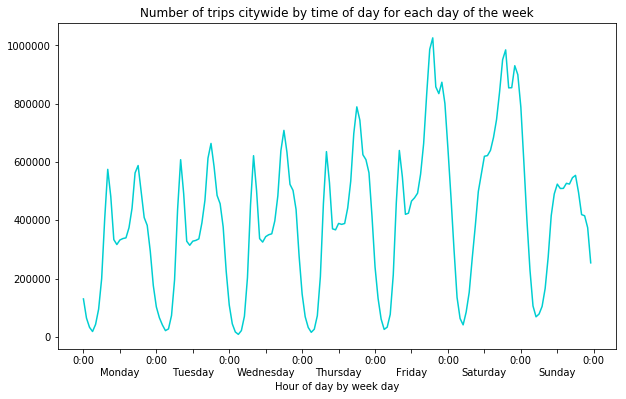

In [39]:
fig = grouped.plot(color='darkturquoise', figsize=(10,6))
plt.xticks(np.arange(0,169,12))
plt.xlabel("Hour of day by week day")
plt.title("Number of trips citywide by time of day for each day of the week")
labels = ["0:00",'\n'+'Monday',"0:00", '\n'+'Tuesday',"0:00", '\n'+'Wednesday',"0:00", '\n'+'Thursday', 
          "0:00",'\n'+'Friday', "0:00",'\n'+'Saturday',"0:00", '\n'+'Sunday', "0:00"]
fig.set_xticklabels(labels);

We see from the above graph that on weekdays (Monday-Thursday), number of trips peaks at around rush hours (~8:00 am and ~6:00 pm). Friday & Saturday in general have the highest number of trips across the week, and Sunday has the lowest number of trips across the week. We also see that on Friday and Saturday, number of trips peaks at around 6:00pm and then peaks again at around 10:00pm.

#### Topic 2: Geographical distribution of ride-hailing demand
**Analyze**

In [16]:
#change from str to integers
tnc_sliced.pickup_census_tract = tnc_sliced.pickup_census_tract.astype(int)
tnc_sliced.dropoff_census_tract = tnc_sliced.dropoff_census_tract.astype(int)
#change from integers to strings
tnc_sliced.pickup_census_tract = tnc_sliced.pickup_census_tract.astype(str)
tnc_sliced.dropoff_census_tract = tnc_sliced.dropoff_census_tract.astype(str)
tnc_sliced.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 15 entries, trip_id to start_hour
dtypes: datetime64[ns](2), object(3), bool(1), float64(7), int64(2)

In [17]:
counts = tnc_sliced.groupby('pickup_census_tract').count().persist()

In [18]:
progress(counts)

VBox()

In [19]:
counts = counts.compute()['trip_id']

In [22]:
counts = pd.DataFrame(counts) 

In [23]:
#merge pickup census tract with census tract shapefile
merged_p = counts.merge(census, left_on='pickup_census_tract', 
                        right_on = 'geoid10', how='left')
merged_p = gpd.GeoDataFrame(merged_p)

**Visualize**

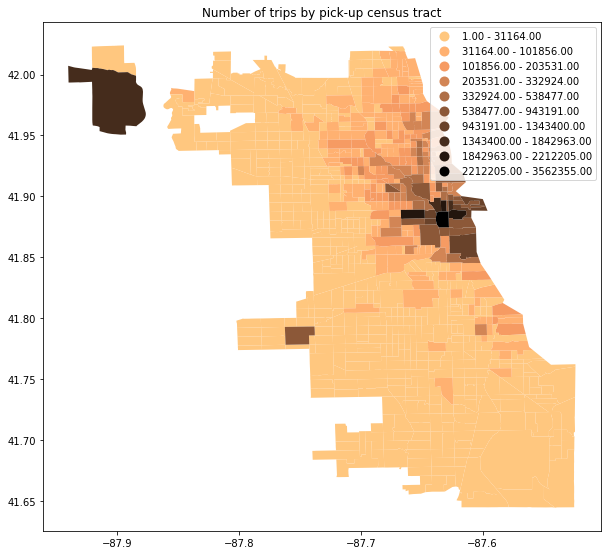

In [24]:
merged_p.plot(column="trip_id", cmap="copper_r", 
              scheme="fisher_jenks", k=10, alpha=1, figsize=(10,10),
              legend=True)
plt.title("Number of trips by pick-up census tract");

From the heat map we see that areas around downtown Chicago, O'hare and Midway airports have the highest number of trips. 

#### Topic 3: Evaluation of Congestion
**Analyze**

In [15]:
#drop the trips with trip_seconds == 0
tnc_sliced = tnc_sliced.query('trip_seconds != 0')

In [16]:
#calculate miles per hour
tnc_sliced['speed'] = tnc_sliced['trip_miles']/tnc_sliced['trip_seconds']*60*60

In [24]:
tnc_weekday = tnc_sliced[tnc_sliced['start_week_day'].isin([0,1,2,3,4])]

In [23]:
tnc_weekday.head(3)

,trip_id,trip_start_timestamp,trip_end_timestamp,trip_miles,trip_seconds,pickup_census_tract,dropoff_census_tract,fare,tip,additional_charges,trip_total,shared_trip_authorized,trips_pooled,start_week_day,start_hour,speed
0,b4c8bc380765526ce1541ae903f5c00bfb2989b8,2018-11-08 19:30:00,2018-11-08 19:45:00,3.3,966.0,1.703133e+10,1.703183e+10,7.5,0.0,2.50,10.00,False,1.0,3,19,12.298137
1,b4c8bde466a18a44df693dd08d37b40950b80270,2019-03-21 07:30:00,2019-03-21 07:45:00,2.0,722.0,1.703108e+10,1.703128e+10,7.5,0.0,2.55,10.05,False,1.0,3,7,9.972299
3,b4c8bdef61b37f7cc37727a3703110db9f455455,2018-12-20 17:00:00,2018-12-20 18:15:00,21.6,3996.0,1.703103e+10,1.703198e+10,37.5,0.0,7.50,45.00,False,1.0,3,17,19.459459


In [25]:
#average speed by hour of day
grouped_speed = tnc_weekday.groupby(['start_hour']).mean().persist()

In [26]:
progress(grouped_speed)

VBox()

In [27]:
grouped_speed = grouped_speed.compute()['speed']

In [28]:
#total trips per hour
grouped_trip = tnc_weekday.groupby(['start_hour']).count().persist()

In [29]:
progress(grouped_trip)

VBox()

In [30]:
grouped_trip = grouped_trip.compute()['trip_id']

**Visualize**

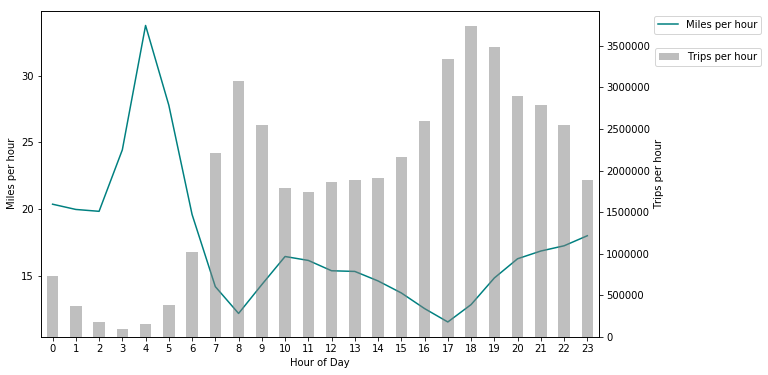

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(grouped_speed, color='teal')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Miles per hour')
ax.legend(['Miles per hour'], bbox_to_anchor=(1.3, 1.0))
ax_twin = ax.twinx() 
grouped_trip.plot.bar(color='gray', alpha=0.5) ##
ax_twin.set_ylabel('Trips per hour')
ax_twin.legend(['Trips per hour'], bbox_to_anchor=(1.3, 0.9));

Average trips per hour peaks at around 18:00 pm. These trips travel the fastest at around 4am in the morning. Trips are slowest during rush hours (8:00 am and 17:00 pm)

#### Topic 4: Evaluation of Ride-Sharing
**Analyze**

In [33]:
#read in economically disconnected areas data
edas = pd.read_csv('edas.csv')
edas = edas[['side','GEOID10']]
edas.GEOID10 = edas.GEOID10.astype(str)
tnc_weekday.pickup_census_tract = tnc_weekday.pickup_census_tract.astype(int).astype(str)
#merge tnc weekday data with data on economically disconnected areas (by census tract ID)
tnc_edas = tnc_weekday.merge(edas, left_on='pickup_census_tract', right_on = 'GEOID10', how='left')

In [34]:
#fill missing values with "non-EDA"
#because the data only marked EDAs
#so the areas not marked are actually non-EDAs
tnc_edas.side = tnc_edas.side.fillna('non-EDA')

In [35]:
noneda = tnc_edas.query('side=="non-EDA"')
north = tnc_edas.query('side=="North/Northwest"')
south = tnc_edas.query('side=="South/Southwest"')
west = tnc_edas.query('side=="West"')

In [36]:
#calculate North percent of shared rides
grouped_north = north.groupby('start_hour')[['shared_trip_authorized','trip_miles']].mean().persist()

In [37]:
progress(grouped_north)

VBox()

In [38]:
grouped_north = grouped_north.compute()

In [40]:
#calculate Non-EDA percent of shared rides authorized
grouped_noneda = noneda.groupby('start_hour')[['shared_trip_authorized','trip_miles']].mean().compute()
#calculate south percent of shared rides authorized
grouped_south = south.groupby('start_hour')[['shared_trip_authorized','trip_miles']].mean().compute()
#calcuate west percent of shared rides authorized
grouped_west = west.groupby('start_hour')[['shared_trip_authorized','trip_miles']].mean().compute()

**Visualize**  
Economically Disadvantaged Areas & Ride Sharing

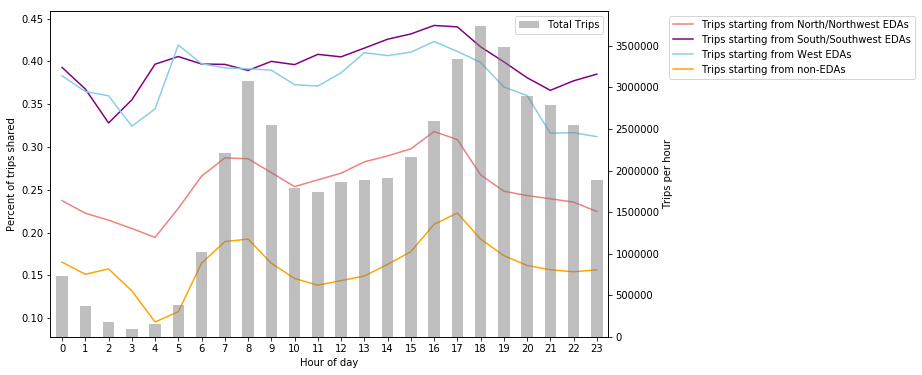

In [41]:
fig, ax= plt.subplots(figsize=(10,6))
ax.plot(grouped_north['shared_trip_authorized'], color='lightcoral')
ax.plot(grouped_south['shared_trip_authorized'], color='purple')
ax.plot(grouped_west['shared_trip_authorized'], color='skyblue')
ax.plot(grouped_noneda['shared_trip_authorized'], color='orange')
ax.legend(['Trips starting from North/Northwest EDAs',
           'Trips starting from South/Southwest EDAs',
           'Trips starting from West EDAs',
           'Trips starting from non-EDAs'], bbox_to_anchor=(1.1,1))
ax.set_xlabel('Hour of day')
ax.set_ylabel('Percent of trips shared')
ax_twin = ax.twinx() 
grouped_trip.plot.bar(color='gray', alpha=0.5)
ax_twin.set_ylabel('Trips per hour')
ax_twin.legend(['Total Trips']);

According to CMAP's reports, EDAs are geographic areas that are not well connected to regional economic progress and have a concentration of low income and minority or limited English proficiency residents. 

We see from the above graph that:   
1) On average, less than 1/3 trips authorized shared rides.   
2) non-EDAs have the lowest percent of shared rides authorized among all four categories.   
3) North-side EDAs have the second lowest % of shared rides, which makes sense given Chicago's income distribution.   
4) The difference between the South and the North is quite large: around 10% difference in % of shared rides authorized.

**Visualize**  
Mean trip length and trips per hour on weekdays by geographic areas

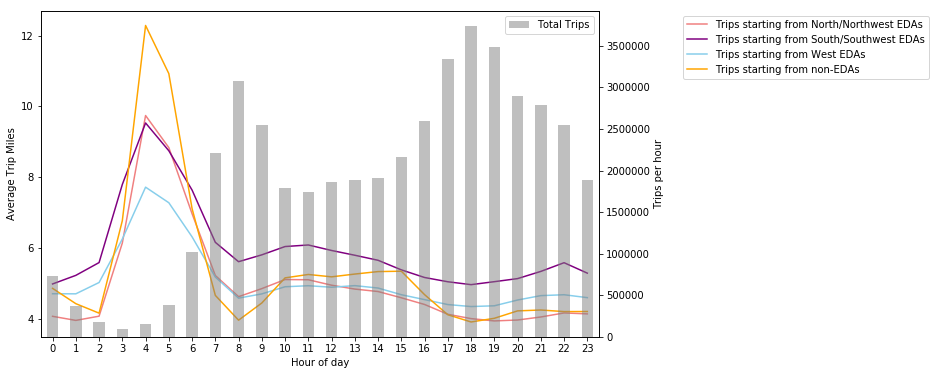

In [53]:
fig, ax= plt.subplots(figsize=(10,6))
ax.plot(grouped_north['trip_miles'], color='lightcoral')
ax.plot(grouped_south['trip_miles'], color='purple')
ax.plot(grouped_west['trip_miles'], color='skyblue')
ax.plot(grouped_noneda['trip_miles'], color='orange')
ax.legend(['Trips starting from North/Northwest EDAs',
           'Trips starting from South/Southwest EDAs',
           'Trips starting from West EDAs',
           'Trips starting from non-EDAs'], bbox_to_anchor=(1.6,1))
ax.set_xlabel('Hour of day')
ax.set_ylabel('Average Trip Miles')
ax_twin = ax.twinx() 
grouped_trip.plot.bar(color='gray', alpha=0.5)
ax_twin.set_ylabel('Trips per hour')
ax_twin.legend(['Total Trips']);

From the above graph we see an interesting pattern: average trip miles is the highest around 5:00 am - 6:00 am, and drops to the lowest at around 9:00 am. Trips starting from non-EDAs have highest average trip miles from 5:00-6:00 am, whereas trips starting from south EDAs have highest average trip miles at other time of the day.